## Introdução
- **Problema**: Muitas fraudes foram identificadas no último ano de um e-commerce;

- **Solução**: Utilizar a base de dados do último ano para tentar entender o que aconteceu e prever possíveis fraudes no futuro;

- **Método**: para análise, visualização e entendimendimento dos dados serão utilizadas bibliotecas como **pandas**, **matiplotlib** e **seaborn**. Para a previsão de novas fraudes serão utilizados modelos do **scikit-learn**.

##1 - Preparação do ambiente e leitura de dados

### Imports

In [ ]:
# 1 - Leitura dos dados
import pandas as pd
import numpy as np
from scipy import special

import itertools
from datetime import timedelta
from IPython.display import display

# 2  - AED (análise exploratória de dados)
import matplotlib.pyplot as plt
import seaborn as sns

# 3 - Engenharia de recursos
from sklearn.ensemble import ExtraTreesClassifier

# 4 - Criando modelos preditivos
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

import random 

from sklearn.svm import OneClassSVM

# 5 - Um modelo mais adequado
from sklearn.tree import DecisionTreeClassifier

### Lendo e explorando os dados

In [ ]:
fraude_df = pd.read_csv('Fraud_Data.csv')
ISP_df = pd.read_csv('IpAddress_to_Country.csv')

In [ ]:
fraude_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

#### Missing values

In [ ]:
# Tabela de missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [ ]:
missing_values_table(fraude_df)

Your selected dataframe has 11 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
missing_values_table(ISP_df)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Describe

In [ ]:
fraude_df.describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [ ]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [ ]:
display(ISP_df[ISP_df.limite_inferior_ip == ISP_df.limite_inferior_ip.max()])
display(ISP_df[ISP_df.limite_inferior_ip == ISP_df.limite_superior_ip.max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3.758096e+09,3758096383,Australia


,limite_inferior_ip,limite_superior_ip,pais


In [ ]:
ip_floats = ISP_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print(f'Número de limites inferiores de endereço IP com decimal não-zero: {ip_floats}')

Número de limites inferiores de endereço IP com decimal não-zero: 0


#### Ajuste no tipo de dado



In [ ]:
# Converte coluna 'limite_inferior_ip' para int
ISP_df.limite_inferior_ip = ISP_df.limite_inferior_ip.astype(int)

### Limpando os dados



In [ ]:
# Classificação com base no número de IP's
def isp_counts(isp):
  pais = ISP_df[(ISP_df.limite_inferior_ip <= isp) & (ISP_df.limite_superior_ip >= isp)].pais

  if pais.shape[0] == 1:
    return print('Único')
  elif pais.shape[0] > 1:
    return print('Vários países')
  elif pais.shape[0] == 0:
    if isp > ISP_df.limite_superior_ip.max():
      return print('Muito Grande')
    elif isp < ISP_df.limite_inferior_ip.min():
      return print('Muito Pequeno')
    else:
      return print('Faltando')

ip_counts = fraude_df.ip.apply(isp_counts)

In [ ]:
# Função para pegar o país com base no IP
def ip_para_pais(ip):
  tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)
              & (ISP_df.limite_superior_ip >= ip)].pais
  if tmp.shape[0] == 1:
    return tmp.iloc[0]
  elif tmp.shape[0] < 1:
    return 'Faltando'
  elif tmp.shape[0] > 1:
    return 'Erro'

In [ ]:
# Cria coluna de PAÍS com base no IP
fraude_df['pais'] = fraude_df.ip.apply(ip_para_pais)

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [ ]:
# Salvando o DF com as alterações
fraude_df.to_csv('Dados_fraude_com_pais.csv')

## 2 - AED (análise exploratória de dados)
Vamos visualizar como o número de fraudes se relaciona com algumas das variáveis

### Gênero

Text(0, 0.5, 'Casos')

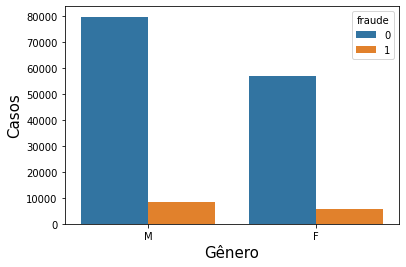

In [ ]:
sns.countplot(x='genero', hue='fraude', data=fraude_df)
plt.xlabel('Gênero', fontsize=15)
plt.ylabel('Casos', fontsize=15)


A proporção de fraudes se mantém para homens e mulheres

### Valor da compra

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Valor de compra')

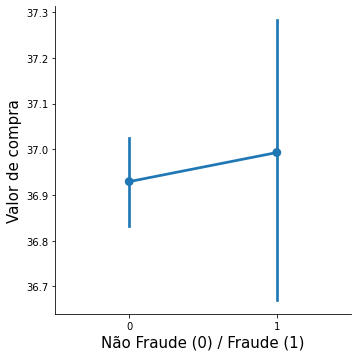

In [ ]:
sns.factorplot(x='fraude', y='valor', data=fraude_df)
plt.xlabel('Não Fraude (0) / Fraude (1)', fontsize=15)
plt.ylabel('Valor de compra', fontsize=15)

Nada pode-se concluir dessa visualização em relação as fraudes.

### Idade

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(-5.825000000000003, 0.5, 'Idade')

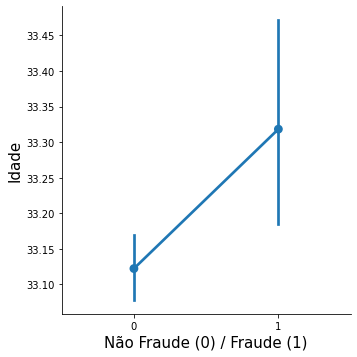

In [ ]:
sns.factorplot(x='fraude', y='idade', data=fraude_df)
plt.xlabel('Não Fraude (0) / Fraude (1)', fontsize=15)
plt.ylabel('Idade', fontsize=15)

O gráfico aparenta mostrar uma tendencia de que as fraudes aparecem em clientes mais velhos, entretanto, ao observarmos o eixo Y, é possível notar que a diferença é de apenas alguns meses, sendo assim pouco relevante.

### Fonte de Marketing

Text(0, 0.5, 'Contagem')

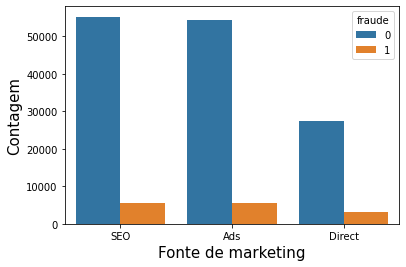

In [ ]:
sns.countplot(x='fonte', hue='fraude', data=fraude_df)
plt.xlabel('Fonte de marketing', fontsize=15)
plt.ylabel('Contagem', fontsize=15)

As proporções parecem se manter, ou seja, o tipo de marketing não é um bom indicativo de fraude. Apesar disso esse gráfico pode ser útil para mostrar que o tipo de marketing 'Direct' não possui a mesma eficiencia que a dos outros.

### País

In [ ]:
# Agrupando os dados por PAÍS
sums_f = fraude_df[fraude_df['fraude']==1]['fraude'].groupby(fraude_df.pais).sum()
sums_f = sums_f.to_frame().reset_index()

sums_nf = fraude_df[fraude_df['fraude']==0]['fraude'].groupby(fraude_df.pais).sum()
sums_nf = sums_nf.to_frame().reset_index()

Text(0, 0.5, 'Países')

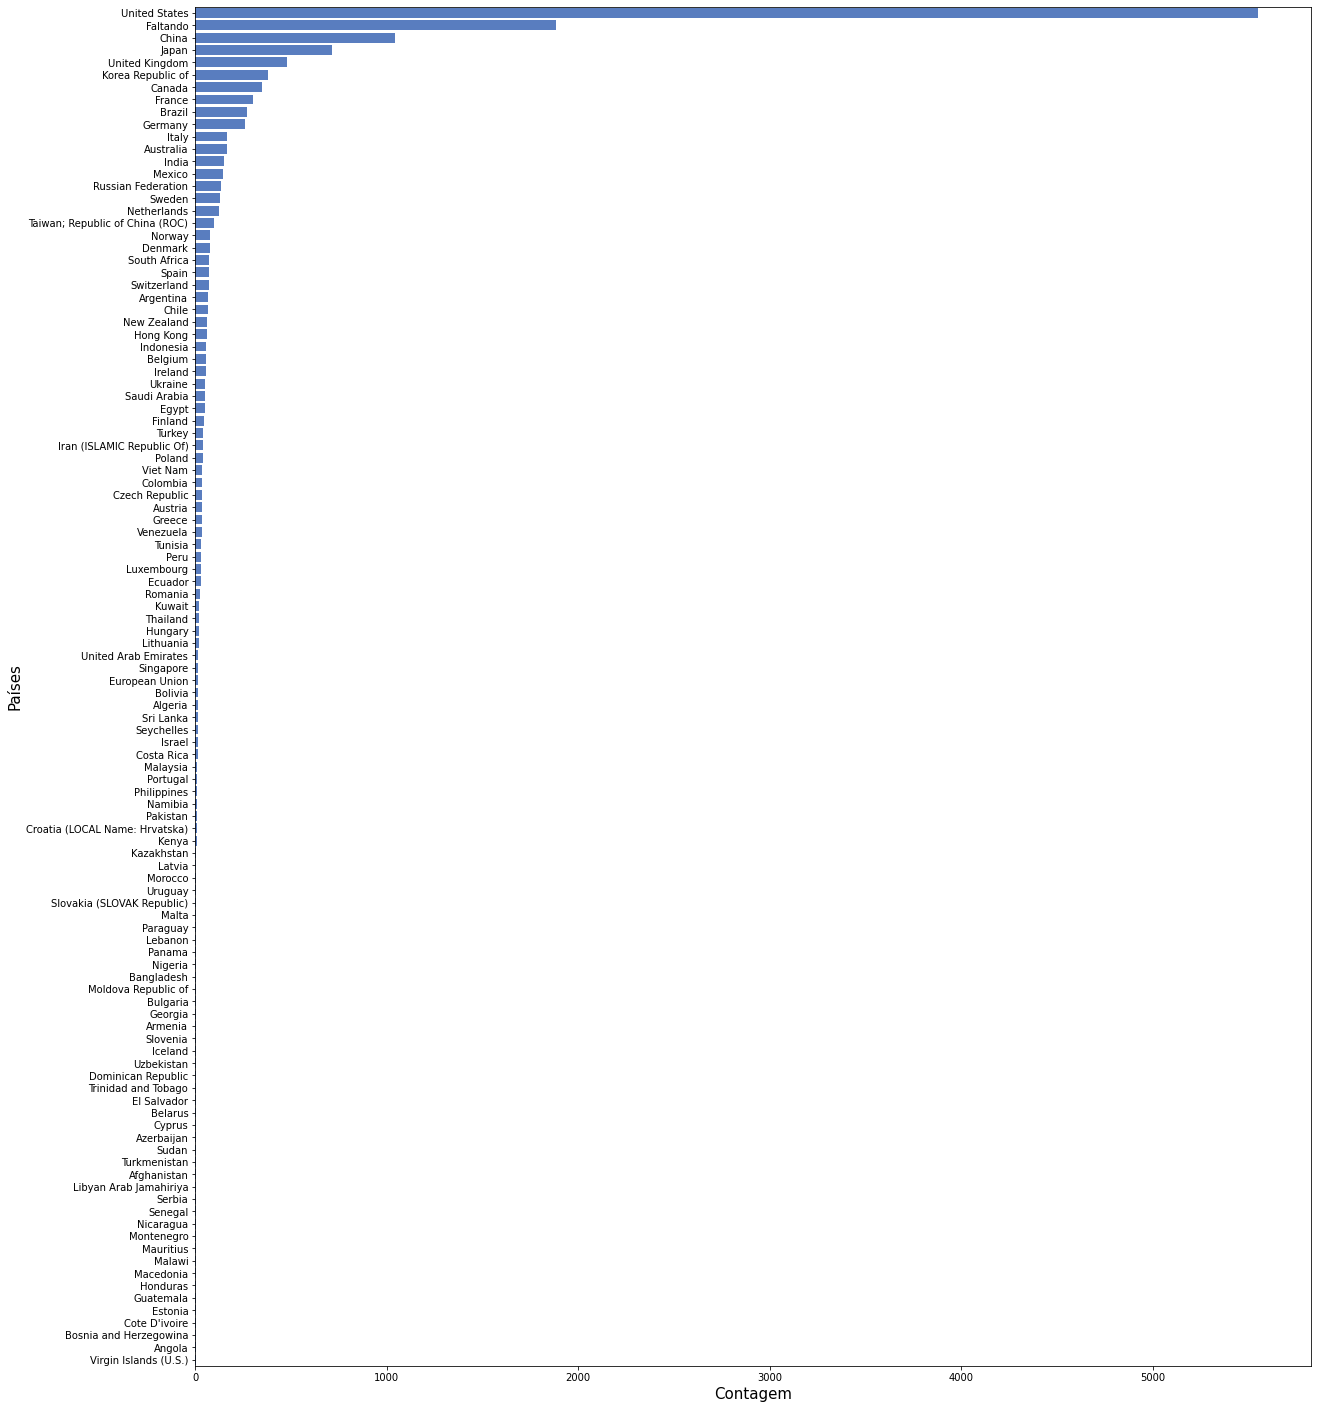

In [ ]:
f, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes('muted')
sns.barplot(x='fraude', y='pais', data=sums_f.sort_values(by=['fraude'], ascending=False), label='Total', color='b')
plt.xlabel('Contagem', fontsize=15)
plt.ylabel('Países', fontsize=15)

Apesar de prover um contexto dos países em que a empres mais atua, não se pode afirmar nada em relação as fraudes com base nesta visualização.

### Investigando número de ID por usuario e por IP

In [ ]:
# DF temporário para gerar as visualizações
tmp_df = pd.DataFrame(columns=('fraude', 'id_por_dispositivo', 'id_por_ip'))
tmp_df['fraude'] = fraude_df['fraude']

userid_count = fraude_df.groupby('id_dispositivo').id.count()
tmp_df['id_por_dispositivo'] = fraude_df.id_dispositivo.apply(lambda x:userid_count[x])

userid_count2 = fraude_df.groupby('ip').id.count()
tmp_df['id_por_ip'] = fraude_df.ip.apply(lambda x:userid_count2[x])



/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(16.299999999999997, 0.5, 'ID de usuário por endereço IP')

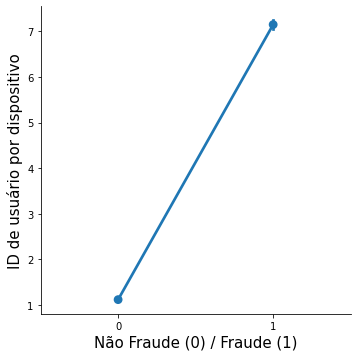

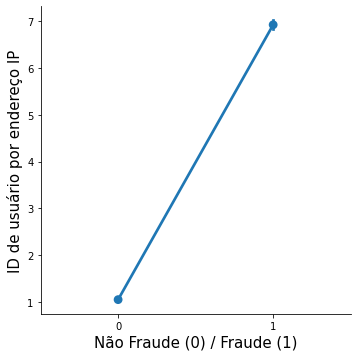

In [ ]:
sns.factorplot(x='fraude', y='id_por_dispositivo', data=tmp_df)
plt.xlabel('Não Fraude (0) / Fraude (1)', fontsize=15)
plt.ylabel('ID de usuário por dispositivo', fontsize=15)

sns.factorplot(x='fraude', y='id_por_ip', data=tmp_df)
plt.xlabel('Não Fraude (0) / Fraude (1)', fontsize=15)
plt.ylabel('ID de usuário por endereço IP', fontsize=15)

Aparentemente existe uma relação forte entre numero de ID's e as fraudes, uma vez que a média de ID's aumenta significativamente para os casos de fraudes.

### Investigando período de compra

In [ ]:
# convertendo o tipo de dado para data
tmp_df["cadastro"] = fraude_df.cadastro.apply(pd.to_datetime)
tmp_df["compra"] = fraude_df.compra.apply(pd.to_datetime)

# função para calcular a diferença de tempo entre compra e cadastro
tmp_df["tempo"] = (tmp_df.compra - tmp_df.cadastro).apply(lambda x: x.seconds)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(-8.825000000000003, 0.5, 'Tempo entre início e compra (segundos)')

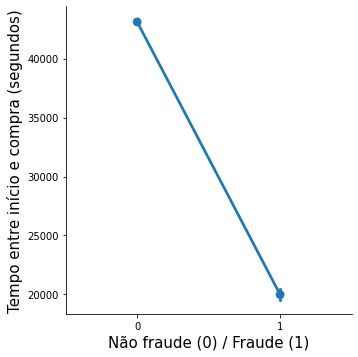

In [ ]:
sns.factorplot(x="fraude", y="tempo", data=tmp_df)
plt.xlabel("Não fraude (0) / Fraude (1)", fontsize=15)
plt.ylabel("Tempo entre início e compra (segundos)", fontsize=15)

Esta visualização revela mais um dado importante: 

Ações fraudulentas tendem a ser mais rápidas, em média duram menos da metade do tempo de ações não fraudulentas.

In [ ]:
tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip,cadastro,compra,tempo
0,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882
1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944
2,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1
3,0,1,1,2015-04-28 21:13:25,2015-05-04 13:54:50,60085
4,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461


É possível perceber nos dados acima que a fraude do item 2 foi uma compra realizada em 1 segundo por um dispositivo com 12 ID's diferentes, ou seja, muito provavelmente a compra foi realizada por um robo.

### Numero de fraudes por **HORA** do **DIA**

Text(0, 0.5, 'Contagem')

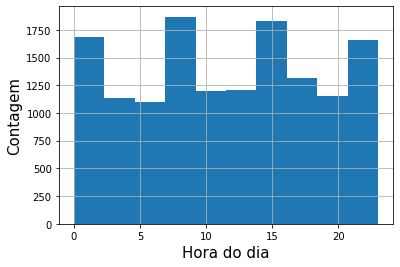

In [ ]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.hour).hist()
plt.xlabel("Hora do dia", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Apesar de apresentar alguns picos, o horário do dia não parece ter grande influência em relação às fraudes.

### Fraudes por **DIA** da **SEMANA**

Text(0, 0.5, 'Contagem')

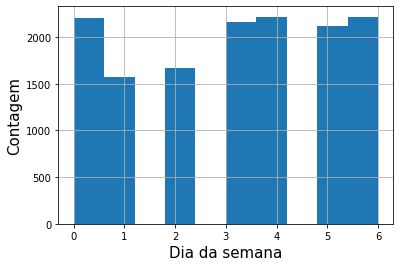

In [ ]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Dia da semana", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

O dia da semana também apresenta pouca influência em relação ao número de faudes.

### Fraudes por **SEMANA** do **ANO**

Text(0, 0.5, 'Contagem')

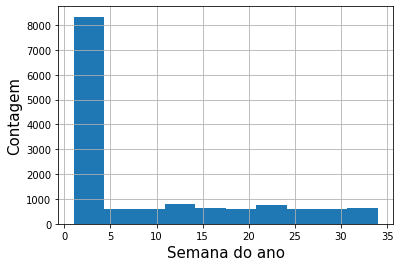

In [ ]:
tmp_df[tmp_df["fraude"] == 1].cadastro.apply(lambda x: x.week).hist()
plt.xlabel("Semana do ano", fontsize=15)
plt.ylabel("Contagem", fontsize=15)

Aparentemente há uma quantidade significativamente maior de fraudes nas primeiras semanas do ano! 

A partir desta visualização pode-se recomendar uma atenção dobrada para a equipe de segurança neste período de início de ano.

## 3 - Engenharia de recursos

### Novas medidas

In [ ]:
# Criando coluna com numero de ID's por dispositivo no DF de fraudes
userid_count3 = fraude_df.groupby("id_dispositivo").id.count()
fraude_df["id_por_dispositivo"] = fraude_df.id_dispositivo.apply(lambda x: userid_count3[x])

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [ ]:
# Criando coluna com numero de ID's por IP no DF de fraudes
userid_count4 = fraude_df.groupby("ip").id.count()
fraude_df["id_por_ip"] = fraude_df.ip.apply(lambda x: userid_count4[x])

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


In [ ]:
# Criando coluna de média de id
fraude_df["media_id"] = (fraude_df.id_por_dispositivo + fraude_df.id_por_ip) * 0.5

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0


In [ ]:
# Convertendo data de compra e de cadastro para datetime
fraude_df.cadastro = fraude_df.cadastro.apply(pd.to_datetime)
fraude_df.compra = fraude_df.compra.apply(pd.to_datetime)

# Criando coluna para medir o tempo de operação
fraude_df["tempo"] = (fraude_df.compra - fraude_df.cadastro).apply(lambda x: x.seconds)

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id,tempo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Faltando,1,1,1.0,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461


In [ ]:
# ONE HOTE ENCODING

from sklearn.preprocessing import OneHotEncoder

ohe_pais = OneHotEncoder(handle_unknown='ignore')
ohe_pais.fit(fraude_df[['pais']])
temp_nomes = ohe_pais.get_feature_names_out()
temp_com_nomes = pd.DataFrame(ohe_pais.transform(fraude_df[['pais']]).toarray())
temp_com_nomes.columns = temp_nomes
temp_com_nomes.head()

,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,pais_Australia,pais_Austria,pais_Azerbaijan,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Tranformando a coluna categórica PAÍS em uma série de colunas numéricas
pais_dummies = pd.get_dummies(fraude_df.pais, prefix='pais')
fraude_df = pd.concat([fraude_df, pais_dummies], axis=1)

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,1,0,0,0,0,0,0,0,0,0


### Removendo medidas

In [ ]:
# Removendo colunas que não serão úteis para nosso modelo
fraude_df.drop(["id",
            "cadastro",
            "compra",
            "id_dispositivo",
            "ip",
            "id_por_dispositivo",
            "id_por_ip",
            "pais",
            "fonte",
            "browser",
            "genero",
            "idade",
            "valor"], axis=1, inplace = True)

### Transformando recursos em Gaussianos (reescalando)

Text(0, 0.5, 'Contagem normalizada')

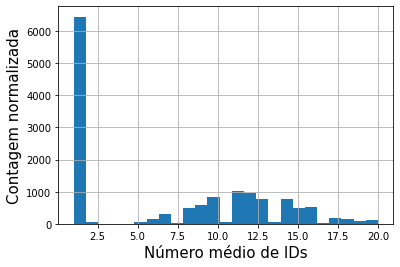

In [ ]:
fraude_df[fraude_df["fraude"] == 1].media_id.hist( bins=25)
plt.xlabel("Número médio de IDs", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

Temos uma distribuição bimodal com um pico inicial bem mais acentuado que o segundo

Text(0, 0.5, 'Contagem normalizada')

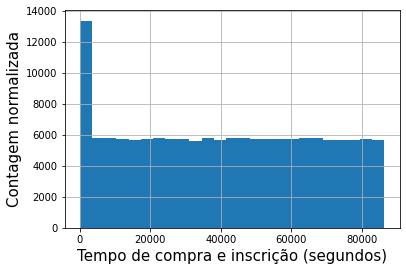

In [ ]:
fraude_df.tempo.hist(bins=25)
plt.xlabel("Tempo de compra e inscrição (segundos)", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

In [ ]:
# Função para reescalar os valores de tempo e facilitar o trabalho do modelo
def rescale_series(ser):
    ser_min = ser.min() - 1e-5
    ser_max = ser.max() + 1e-5
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    new_ser = new_ser.apply(lambda x: np.sqrt(2)*special.erfinv(2*x - 1))
    return new_ser

Text(0, 0.5, 'Contagem normalizada')

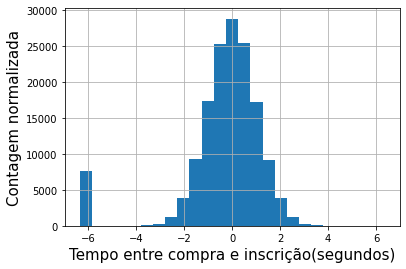

In [ ]:
fraude_df["tempo"] = rescale_series(fraude_df.tempo)
fraude_df.tempo.hist(bins=25)
plt.xlabel("Tempo entre compra e inscrição(segundos)", fontsize=15)
plt.ylabel("Contagem normalizada", fontsize=15)

Agora temos nossos dados representados numa distribuição normal, apesar de ainda termos o pico inicial representado

Agora vamos reescalar todas as colunas (exceto as de PAÍS) para assumirem valores entre 0 e 1, isso também deve facilitar o trabalho do nosso modelo.

In [ ]:
# Função para reescalar colunas entre 0 e 1
def rescale_series(ser):
    ser_min = ser.min()
    ser_max = ser.max()
    new_ser = (ser - ser_min) / (ser_max - ser_min)
    return new_ser

onehotencoded = [feature for feature in fraude_df.columns if "pais" not in feature and feature != "fraude"]

# Aplicando a função em todas as colunas, exceto as de PAÍS
for col in onehotencoded:
    fraude_df[col] = rescale_series(fraude_df[col])

    X = fraude_df[ [col for col in fraude_df.columns if col != "fraude"]]
    Y = fraude_df["fraude"]

In [ ]:
# Salvando os dados
X.to_csv("X.csv", index=False)
Y.to_csv("Y.csv", index=False)

### Identificando variáveis importantes

Vamos agora conferir quais das nossas variáveis são mais relevantes. Isso é importante principalmente neste caso já que temos muitas colunas, o que pode atrasar o treinamento do modelo.

In [ ]:
clf = ExtraTreesClassifier()
_ = clf.fit(X,Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_

features[features.importancia > np.mean(features.importancia)].sort_values(by="importancia", ascending=False)

,feature,importancia
1,tempo,0.658918
0,media_id,0.335547


As variáveis TEMPO e MEDIA_ID são usoladamente as mais relevantes do nosso conjunto de dados, sendo resonsáveis por mais de 99% da importância.

## 4 - Criando modelos preditivos

### Treinando o modelo

In [ ]:
# Dividindo dados de treino e teste
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size = 0.75, random_state = 23)

# o modelo IsolationForest espera os valores 1 e -1
Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

In [ ]:
# Buscando o melhor valor para o parâmetro n_estimators com GridSerch CV (processo bastante demorado)
IF = IsolationForest(max_samples="auto", contamination = 0.095, random_state=1)
param_grid = {"n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500]}

clf = GridSearchCV(IF,
                param_grid,
                cv=5,
                n_jobs=10,
                scoring="f1",
                verbose=10)

clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


GridSearchCV(cv=5,
             estimator=IsolationForest(contamination=0.095, random_state=1),
             n_jobs=10,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             scoring='f1', verbose=10)

Podemos agora conferir o nosso melhor modelo:

In [ ]:
IF_best = clf.best_estimator_
IF_best

IsolationForest(contamination=0.095, n_estimators=500, random_state=1)

### Curva ROC

              precision    recall  f1-score   support

     anomalo       0.79      0.55      0.65      4221
      normal       0.86      0.95      0.90     12351

    accuracy                           0.85     16572
   macro avg       0.82      0.75      0.77     16572
weighted avg       0.84      0.85      0.84     16572

Area sob a curva ROC: {:0, 3f} 0.7480678141153999


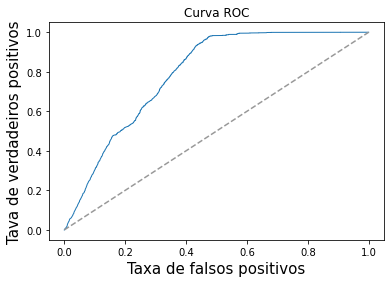

In [ ]:
Y_predicted = IF_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print (classification_report(Y_eval,
                Y_predicted,
                target_names=["anomalo","normal"]))
print("Area sob a curva ROC: {:0, 3f}", format(roc_auc))

IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, threshold = roc_curve(Y_eval, IF_probs)

plt.plot(fpr, tpr, lw=1)

plt.plot([0,1],[0,1], '--', color=(0.6,0.6,0.6), label="sorte")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel("Taxa de falsos positivos", fontsize=15)
plt.ylabel("Tava de verdadeiros positivos", fontsize=15)
plt.title("Curva ROC", fontsize=12)

plt.show()

### Matriz de confusão

In [ ]:
cnf_matrix_IF = confusion_matrix(Y_eval, Y_predicted)
print('Matriz de Confusão:')
print(cnf_matrix_IF)

Matriz de Confusão:
[[ 2303  1918]
 [  611 11740]]


Padrão seguido da Matriz de confusão:

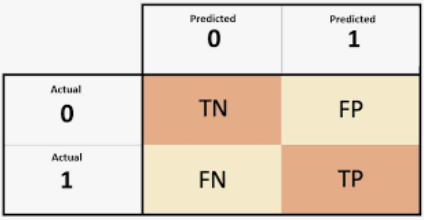


### Modelo não supervisionado

#### Arrumando os dados

In [ ]:
# Destuno de volta ao conjunto de recursos
X['fraude'] = Y

#Divide entre anomalias e normal
X_anomalias = X[X['fraude'] == 1]
X_normal = X[X['fraude'] == 0]

# Amostra de 70% do conjunto de dados 'normal' para treino
train_idxs = random.sample(list(X_normal.index), int(0.7*X_normal.shape[0]))
X_train = X_normal.loc[train_idxs]

# Conjunto de teste une o que sobrou do conjunto 'normal' com o conjunto 'anomalia'
X_testing = X_normal.drop(train_idxs)
X_testing = pd.concat([X_testing, X_anomalias], axis=0)

# Embaralha os dados e reseta o índice
X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

# Movendo a coluna 'fraude' para Y_testing
Y_testing = X_testing['fraude']
X_testing = X_testing [[col for col in X_testing.columns if col != 'fraude']]

# Divide os dados
X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing, Y_testing, train_size = 0.7, random_state=23)

# Padroniza para o modelo
Y_cv = Y_cv.apply(lambda x: 1 if x==0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x==0 else -1)

# Removendo a coluna 'fraude'
X_train = X_train[ [col for col in X_testing.columns if col != 'fraude']]

#### Procurando o melhor modelo

In [ ]:
# Parâmetros de teste
param_grid = {"nu": np.linspace(0.001, 0.01, 5), "gamma": [0.01, 0.03, 0.1, 0.3]}

param_list = list(itertools.product(param_grid["nu"],param_grid["gamma"]))

In [ ]:
# Função para gridsearch aleatório
def random_gridsearch(param_list, n_sample, X_train, X_cv, Y_cv):

    f1_max = 0
    param_list = random.sample(param_list, n_sample)
    remaining_fits = n_sample
    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)
        print('Fitando modelo...')
        OCSVM.fit(X_train)

        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average="binary")

        if f1 > f1_max:
            f1_max = f1
            OCSVM_best = OCSVM

            remaining_fits -=1

    return f1_max, OCSVM

In [ ]:
f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, Y_cv)

Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...
Fitando modelo...


### Curva ROC

              precision    recall  f1-score   support

    anormais       0.96      0.54      0.69      4289
     normais       0.86      0.99      0.92     12283

    accuracy                           0.88     16572
   macro avg       0.91      0.77      0.81     16572
weighted avg       0.89      0.88      0.86     16572

Área sob a curva ROC: {:0.3f} 0.767559963370263


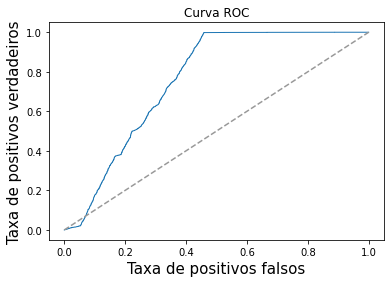

In [ ]:
OCSVM_best.fit(X_train)
Y_predicted = OCSVM_best.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

print(classification_report(Y_eval,
                            Y_predicted,
                            target_names=['anormais', 'normais']))

print('Área sob a curva ROC: {:0.3f}', format(roc_auc))

OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, threshold = roc_curve(Y_eval, OCSVM_probs)

plt.plot(fpr, tpr, lw=1, label='ROC')
plt.plot([0,1], [0,1], '--', color=[0.6, 0.6, 0.6], label='sorte')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC')

plt.show()

In [ ]:
print('Matriz de Confusão:')
print(confusion_matrix(Y_eval, Y_predicted))

Matriz de Confusão:
[[ 2329  1960]
 [   97 12186]]


## 5 - Um modelo mais adequado

Vamos agora testar uma DecisionTree ao invés de uma Isolation Forest

              precision    recall  f1-score   support

    anormais       0.96      0.89      0.92      4289
     normais       0.96      0.99      0.97     12283

    accuracy                           0.96     16572
   macro avg       0.96      0.94      0.95     16572
weighted avg       0.96      0.96      0.96     16572

Área sob a curva ROC: 0.936


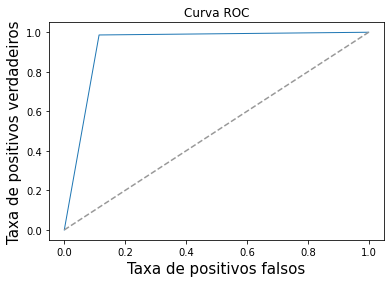

In [ ]:
# Cira e treina o modelo
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_dev, Y_dev)

# Previsões
Y_predicted = decision_tree.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, Y_predicted)

cv_preds = decision_tree.predict(X_cv)
print(classification_report(Y_eval,
                            Y_predicted,
                            target_names=['anormais', 'normais']))

print('Área sob a curva ROC: {:0.3f}'. format(roc_auc))

dt_probs = decision_tree.predict_proba(X_eval)
fpr, tpr, _ = roc_curve(Y_eval, Y_predicted)

plt.plot(fpr, tpr, lw=1, label='ROC')
plt.plot([0,1], [0,1], '--', color=[0.6, 0.6, 0.6], label='sorte')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC')

plt.show()

As métricas para esse modelo são significativamente melhoras que a dos modelos anteriores, especialmente devido a área sob a curva ser maior.

In [ ]:
print('Matriz de Confusão:')
print(confusion_matrix(Y_eval, Y_predicted))

Matriz de Confusão:
[[ 3799   490]
 [  169 12114]]


A matriz de confusão também apresenta um resultado bem mais satisfatório para o modelo de DecisionTree

## Conclusões finais:
A partir destes resultados pode-se concluir que:
- Nem todos os endereços de IP podem ser rastreados
- O país de origem não representa uma informação importante para identificar fraudes
- As características mais importantes são: o intervalo de **TEMPO** da inscrição até a compra e o **NÚMERO DE ID's** 
- O modelo não supervisionado possui uma precisão inferior comparado ao supervisionado, sendo o modelo DecisionTree o mais adequado entre os modelos testados.

## Recomendações:
- Exigir nome completo do usuário e e-mail para inscrição
- Oferecer ofertas e descontos em potencial logo após inscrição para tentar prolongar o tempo e diferenciar o usuário humano de um usuário robo
- Aumentar a segurança nos primeiros mêses do ano
- Pedir para responder perguntas de segurança os CAPTCHAS caso seja identificado como possível fraude